# FusionSolarPy


A python client for the HuaweiFusionSolar API used to monitor solar power plants.
For use of this api there is thus no openAPI account needed, your normal credentials to log in to the web portal should work.
This client had 2 main goals:

- being able to retreive realtime statistics and change parameters for use in Home Assistant -> see this integration: https://github.com/janmolemans/huawei_fusionsolar
- being able to retreive historical statistics for plotting and stuff

This client uses the https://region01eu5.fusionsolar.huawei.com end point by default. It is
possible to change this using the `huawei_subdomain` parameter.

Please report any bugs!


This file is a markdown export of the readme.ipynb notebook.

`jupyter nbconvert readme.ipynb --to markdown`


# Install


`pip install huawei-fusionsolar`


# Example usage


In [30]:
%reload_ext autoreload
%autoreload 2

In [31]:
from src.fusion_solar_py.client import FusionSolarClient, LOCAL_TIMEZONE

# from fusion_solar_py.client import FusionSolarClient
import json


## Create client


In [32]:
# log into the API  with proper credentials...
# Read YAML file
ROOT_DIR = "."

import json

try:
    with open(f"{ROOT_DIR}/tests/credentials.json", "r") as stream:
        cred = json.load(stream)
except FileNotFoundError:
    # fill in your credentials here
    cred = {"username": "FILL_IN", "password": "FILL_IN", "subdomain": "FILL_IN"}


client = FusionSolarClient(
    cred["username"], cred["password"], huawei_subdomain=cred["subdomain"]
)


## Plants


In [33]:
plants = client.get_plants()

In [34]:
for plant in plants:
    print(plant.name)
    # print(json.dumps(plant.get_plant_flow(), indent=4))
    # r= plant.get_plant_stats(return_resp=True)


steenhof huawei


## Devices


In [35]:
devices = client.get_devices()

### Save data from devices

In [36]:
import pandas
import datetime
import os
import time


df_dic = {}
for device in devices:
    if device.type == "Dongle":
        continue
    print(device.type)
    path = f"data/{device.type.replace(' ','_')}.pkl"
    if os.path.exists(path):
        df_existing = pandas.read_pickle(path)
        last_date = (
            pandas.to_datetime(df_existing.index.max(), unit="s", utc=True)
            .tz_convert(tz=LOCAL_TIMEZONE).tz_convert(None).date()
        )
        min_ts=df_existing.index.max()-24*3600
    else:
        df_existing = pandas.DataFrame()
        min_ts = 0


    df = pandas.DataFrame()

    ts=time.time()
    while ts > min_ts:
        print(pandas.to_datetime(ts, unit="s", utc=True))
        df_temp = device.get_hist_device_stats(query_time=int(ts * 1000)) 
        if (len(df_temp) == 0): # or (i > 5):
            break
        df = pandas.concat([df_temp, df])
        ts=df_temp.index.min()-12*3600 #nicely in the middle of the previous day

    if df_existing is not None:
        df = pandas.concat([df_existing, df])

    df["start"] = pandas.to_datetime(df.index, unit="s", utc=True).tz_convert(tz=None)
    if device.type == "Battery":
        for col in ["Charging", "Discharging"]:
            cumsum = []
            offset = 0
            prev_val = 0
            for val in df[col]:
                if val < prev_val:
                    # new day
                    offset = offset + prev_val
                cumsum.append(val + offset)
                prev_val = val
            df[f"{col}_total"] = cumsum
    df_dic[device.type] = df.drop_duplicates()
    df.to_pickle(path)


Inverter
2022-10-22 21:58:58.538546944+00:00
Power Sensor
2022-10-22 21:58:59.275711744+00:00


### Query each device for latest metrics


In [56]:
units = set()
values = []
for device in devices:
    for metric in device.get_device_stats().values():
        print(metric.name, metric.value, metric.unit)
        units.add(metric.unit)
        # values.append(metric.value)
        break  # uncomment for more prints
    # print(device.name, device.type)
    # print(json.dumps(device.get_device_stats(), indent=4))
    # r= device.get_device_stats(return_resp=True)
    # break


PV energy yield power 0.000 kW
Inverter rated power 8.000 kW
Status Normal 


## Plot historical metrics


In [57]:
import time
import datetime
import pandas

pandas.options.plotting.backend = "plotly"

# query_time=int(pandas.Timestamp.now(tz=LOCAL_TIMEZONE).floor('d').timestamp()*1000)
query_time = int(
    pandas.Timestamp(year=2022, month=8, day=1, tz=LOCAL_TIMEZONE)
    .floor("d")
    .timestamp()
    * 1000
)

df = plants[0].get_plant_stats(query_time=query_time, time_dim=2)

fig = df.plot()
# fig # uncomment for the interactive plotly figure


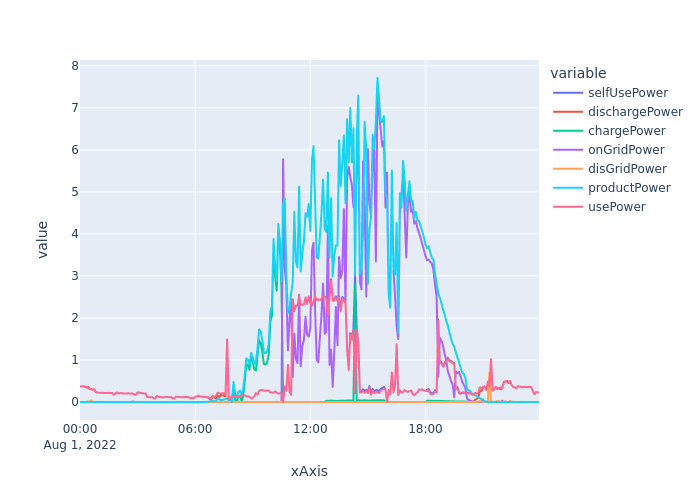

In [58]:
# save to static image for use in readme file

img_bytes = fig.to_image(format="png")
from IPython.display import Image

Image(img_bytes)
